# Figure 6: Individual risk versus household size neighbourhood 1 and r

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve
import pandas as pd

### Importing required scripts

In [2]:
import importlib
import Keeling_model
import R_star_construct

importlib.reload(Keeling_model)
importlib.reload(R_star_construct)

ODEHouseholds2 = Keeling_model.ODEHouseholds2
ConfigsConstruct = Keeling_model.ConfigsConstruct
RstarAnal = R_star_construct.RstarAnal

### Parameters

In [3]:
h1,h2 = 2520,2520            # no. of households in each neighbourhood
n1,n2 = 2,2                  # size of households for each neighbourhood
Inf1,Inf2 = 1,1              # initial no. of infections in each neighbourhood
gamma = 0.2                  # recovery rate from infection
days = 100                   # no. of days in simulation
tStart, tEnd = 0, days       # start time and end time (days) of simulation
tEval = np.linspace(tStart, tEnd)    # output points

N2 = 5040                    # Neighbourhood (2) population size

In [4]:
## constructing rho

N_neigh = 2               # no. of neighbourhoods
H = np.array([h1,h2])     # array of number of households in each neighbourhood
N = np.array([n1,n2])     # array of household size for each neighbourhood

p_reserve = np.array([0,0])            # proportion of contacts reserved for own neighbourhood
rho = np.zeros((N_neigh,N_neigh))      # initialising array to store rho values

for i in range(N_neigh): 
    for j in range(N_neigh):
        rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
    rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))

In [5]:
## fixing contact rates alpha and beta

nu = 3      # good range 1 to 6
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu
alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Solve coupled ODE system to obtain proportions of infected individuals in each neighbourhood (by end of sim) 
#### Over range of household sizes for neighbourhood 1

In [6]:
nVec = np.arange(2,7)              # list of household sizes neighbourhood 1
outVec1 = np.zeros(len(nVec))      # initialise array to store no. of infected individuals in neighbourhood 1
outVec2 = np.zeros(len(nVec))      # neighbourhood 2

for i in range(len(nVec)):
    n2 = nVec[i]
    h2 = int(N2/n2)
    
    configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations
    configs2,n_configs2 = ConfigsConstruct(n2)
    
    rvec1 = [config1.count('r') for config1 in configs1]  # list of numbers of recovered individuals in the neighbourhood 1 household configurations
    rvec2 = [config2.count('r') for config2 in configs2]  # neighbourhood 2
    ivec1 = [config1.count('i') for config1 in configs1]  # list of numbers of infectious individuals in the neighbourhood 1 household configurations
    ivec2 = [config2.count('i') for config2 in configs2]  # neighbourhood 2

    y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
    y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
    y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
    y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
    y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected
    
    params = (beta, beta, alpha, alpha, rho[0,0], rho[1,1], gamma, n1, n2, h1, h2)
    sol = solve_ivp(ODEHouseholds2, y0 = y0, method='LSODA', t_span = [tStart, tEnd], t_eval = tEval, args=params)    # solve the differential equation system
    sol_df = pd.DataFrame(np.transpose(sol.y))  # bung output into dataframe, columns are state x config y, rows are days
    # retrieve proportion infected in neighbourhoods
    Inf1_propn = np.sum(sol_df.loc[:,:n_configs1-1]*rvec1,1)/n1 + np.sum(sol_df.loc[:,:n_configs1-1]*ivec1,1)/n1
    Inf2_propn = np.sum(sol_df.loc[:,n_configs1:]*rvec2,1)/n2 + np.sum(sol_df.loc[:,n_configs1:]*ivec2,1)/n2
    # no. infected each neighbourhood
    outVec1[i] = Inf1_propn[len(tEval)-1]*n1*h1
    outVec2[i] = Inf2_propn[len(tEval)-1]*n2*h2

### Producing figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


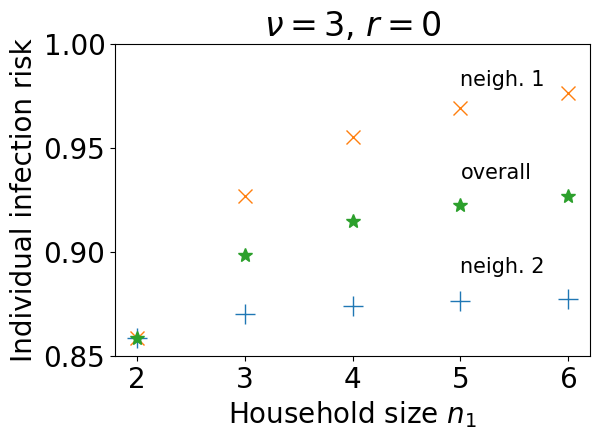

In [7]:
plt.rcParams.update({'font.size': 20})
plt.plot(nVec,outVec1/(n1*h1), '+', markersize = 15,label='neighbourhood 1')  # plot proportion infected neigh 1 vs household size neigh 1
plt.plot(nVec,outVec2/(n2*h2), 'x', markersize = 10,label='neighbourhood 2')  # proportion infected neigh 2
plt.plot(nVec,(outVec1+outVec2)/(n1*h1+n2*h2), '*', markersize = 10, label='overall')  # averaged over neighbourhoods 
plt.annotate('neigh. 1', xy=(5,0.98), fontsize=15)
plt.annotate('neigh. 2', xy=(5,0.89), fontsize=15)
plt.annotate('overall', xy=(5,0.935), fontsize=15)

plt.ylim(0.85,1)
plt.xticks([2,3,4,5,6])
plt.xlabel(r'Household size $n_1$')
plt.ylabel('Individual infection risk')
plt.title(r'$\nu=${}, $r=${}'.format(nu,0))
plt.tight_layout()
plt.savefig('Ind_risk.pdf')

#### Over range of r values, the proportion of contacts reserved for your own neighbourhood

In [8]:
plt.rcParams.update({'font.size': 20})
pvec = np.arange(0,1.1,0.1)       # array of r values
outVec11 = np.zeros(len(pvec))    # initialise array to store no. of infected individuals in neighbourhood 1
outVec22 = np.zeros(len(pvec))    # neighbourhood 2

configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations
configs2,n_configs2 = ConfigsConstruct(n2)
    
rvec1 = [config1.count('r') for config1 in configs1]  # list of numbers of infectious individuals in the neighbourhood 1 household configurations
rvec2 = [config2.count('r') for config2 in configs2]  # neighbourhood 2
ivec1 = [config1.count('i') for config1 in configs1]  # list of numbers of infectious individuals in the neighbourhood 1 household configurations
ivec2 = [config2.count('i') for config2 in configs2]  # neighbourhood 2

ind_i1 = [1 if ivec1_ > 0 else 0 for ivec1_ in ivec1]
ind_i2 = [1 if ivec2_ > 0 else 0 for ivec2_ in ivec2]
ind_r1 = [1 if rvec1_ > 0 else 0 for rvec1_ in rvec1]
ind_r2 = [1 if rvec2_ > 0 else 0 for rvec2_ in rvec2]

y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected

for i in range(len(pvec)):                         # looping over the range of r values
    p_reserve = np.array([pvec[i],pvec[i]])
    rho = np.zeros((N_neigh,N_neigh))              # initialising array to store rho values each iteration
    
    if pvec[i] == 1:                               # if r=1, use separate case to avoid division by 0
            rho[0,0] = 1
            rho[1,1] = 1
    else:
        for k in range(N_neigh):                   # define rho from r
            for j in range(N_neigh):
                rho[k,j] = (1-p_reserve[k])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
            rho[k,k] = p_reserve[k] + (1-p_reserve[k])*(1-p_reserve[k])*H[k]*N[k]/(np.sum((1-p_reserve)*H*N))
        
    params = (beta, beta, alpha, alpha, rho[0,0], rho[1,1], gamma, n1, n2, h1, h2)
    sol = solve_ivp(ODEHouseholds2, y0 = y0, method='LSODA', t_span = [tStart, tEnd], t_eval = tEval, args=params)    # solve the differential equation system
    sol_df = pd.DataFrame(np.transpose(sol.y))  # bung output into dataframe, columns are state x config y, rows are days
    Inf1_propn = np.sum(sol_df.loc[:,:n_configs1-1]*rvec1,1)/n1 + np.sum(sol_df.loc[:,:n_configs1-1]*ivec1,1)/n1
    Inf2_propn = np.sum(sol_df.loc[:,n_configs1:]*rvec2,1)/n2 + np.sum(sol_df.loc[:,n_configs1:]*ivec2,1)/n2
    outVec11[i] = Inf1_propn[len(tEval)-1]*n1*h1
    outVec22[i] = Inf2_propn[len(tEval)-1]*n2*h2   
    

### Producing figure

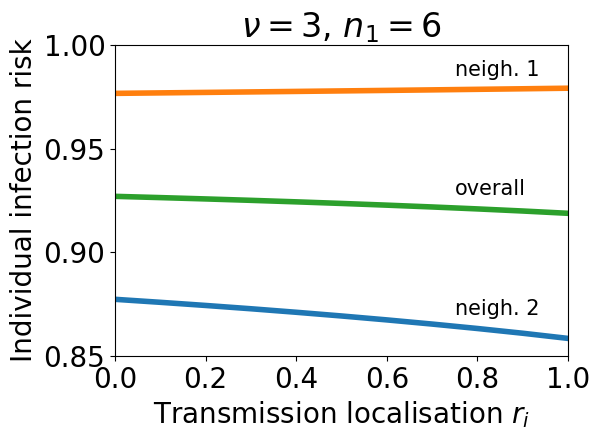

In [9]:
plt.plot(pvec,outVec11/(n1*h1), linewidth=4,label='neighbourhood 1, size 4')   # plotting propn infected in neighbourhood 1 vs r
plt.plot(pvec,outVec22/(n2*h2), linewidth=4,label='neighbourhood 2, size 2')   # neighbourhood 2
plt.plot(pvec,(outVec11+outVec22)/(n1*h1+n2*h2), linewidth=4, label ='overall')
plt.xlabel(r'Transmission localisation $r_i$')
plt.ylabel('Individual infection risk')
plt.annotate('neigh. 1', xy=(0.75,0.985), fontsize=15)
plt.annotate('neigh. 2', xy=(0.75,0.87), fontsize=15)
plt.annotate('overall', xy=(0.75,0.9275), fontsize=15)

plt.xlim(0,1)
plt.yticks([0.85,0.90,0.95,1.0])
plt.title(r'$\nu=${}, $n_1=${}'.format(nu,n2))
plt.tight_layout()
plt.savefig('Coupling_risk.pdf')

Individual infection risk over entire outbreak when neighbourhoods have different household sizes and the strength of localisation between the neighbourhoods are varied. (a) Household size in neighbourhood $1$ is varied from $2$ to $6$ and $n_2=2$. Individual infection risks of individuals from neighbourhood $1$, $2$ and overall are shown as blue crosses, orange pluses and blue stars respectively. Infection risk is defined as the probability an individual is infected by the time the outbreak ends. (b) $n_1=6$ and $n_2=2$. The localisation of the contacts of the two neighbourhoods is varied from isolated to proportional mixing. Individual risk of those from neighbourhood $1$, $2$ and overall are displayed as blue, orange and green curves respectively.